# M2177.003100 Deep Learning <br> Assignment #1 Part 1: Data Curation Practices

Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. 

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

**Note**: Certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem. The *Exercises* are self-evaluated assignments(**they are not included in your assignment score**). However, you must go through the exercises to perform well in further assignments.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **part 1 - 3**, run the *CollectSubmission.sh* script with your **Student number** as input argument. PLEASE comment any print/plot function in *Excercises* on submission. <br>
This will produce a compressed file called *[Your student number].tar.gz*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; 20\*\*-\*\*\*\*\*)

## Download datasets

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [54]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline
# PLEASE Comment this line on submission

In [3]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = './data' # Change me to store data elsewhere

if not os.path.exists(data_root):
  os.makedirs(data_root)

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
          'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./data/notMNIST_large.tar.gz
Found and verified ./data/notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
    # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(
          'Expected %d folders, one per class. Found %d instead.' % (
            num_classes, len(data_folders)))
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./data/notMNIST_large already present - Skipping extraction of ./data/notMNIST_large.tar.gz.
['./data/notMNIST_large/A', './data/notMNIST_large/B', './data/notMNIST_large/C', './data/notMNIST_large/D', './data/notMNIST_large/E', './data/notMNIST_large/F', './data/notMNIST_large/G', './data/notMNIST_large/H', './data/notMNIST_large/I', './data/notMNIST_large/J']
./data/notMNIST_small already present - Skipping extraction of ./data/notMNIST_small.tar.gz.
['./data/notMNIST_small/A', './data/notMNIST_small/B', './data/notMNIST_small/C', './data/notMNIST_small/D', './data/notMNIST_small/E', './data/notMNIST_small/F', './data/notMNIST_small/G', './data/notMNIST_small/H', './data/notMNIST_small/I', './data/notMNIST_small/J']


---
Excercise 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display Image method.

---

In [5]:
import random

dataset = {'train': train_folders, 'test': test_folders}

for key, value in dataset.items():
    print("\n<" + key + ">\n")
    for folder in value:
        print(folder)
        image_path = random.choice(os.listdir(folder))
        display(Image(filename=os.path.join(folder, image_path)))


<train>

./data/notMNIST_large/A


./data/notMNIST_large/B


./data/notMNIST_large/C


./data/notMNIST_large/D


./data/notMNIST_large/E


./data/notMNIST_large/F


./data/notMNIST_large/G


./data/notMNIST_large/H


./data/notMNIST_large/I


./data/notMNIST_large/J



<test>

./data/notMNIST_small/A


./data/notMNIST_small/B


./data/notMNIST_small/C


./data/notMNIST_small/D


./data/notMNIST_small/E


./data/notMNIST_small/F


./data/notMNIST_small/G


./data/notMNIST_small/H


./data/notMNIST_small/I


./data/notMNIST_small/J


## Load datasets

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [42]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:            
            image_data = (plt.imread(image_file, 0).astype(float) - 
                        pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                        (num_images, min_num_images))

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
          # You may override by setting force=True.
          print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)

    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./data/notMNIST_large/A.pickle already present - Skipping pickling.
./data/notMNIST_large/B.pickle already present - Skipping pickling.
./data/notMNIST_large/C.pickle already present - Skipping pickling.
./data/notMNIST_large/D.pickle already present - Skipping pickling.
./data/notMNIST_large/E.pickle already present - Skipping pickling.
./data/notMNIST_large/F.pickle already present - Skipping pickling.
./data/notMNIST_large/G.pickle already present - Skipping pickling.
./data/notMNIST_large/H.pickle already present - Skipping pickling.
./data/notMNIST_large/I.pickle already present - Skipping pickling.
./data/notMNIST_large/J.pickle already present - Skipping pickling.
./data/notMNIST_small/A.pickle already present - Skipping pickling.
./data/notMNIST_small/B.pickle already present - Skipping pickling.
./data/notMNIST_small/C.pickle already present - Skipping pickling.
./data/notMNIST_small/D.pickle already present - Skipping pickling.
./data/notMNIST_small/E.pickle already present -

---
Exercise 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. *Hint*: you can use matplotlib.pyplot.

---

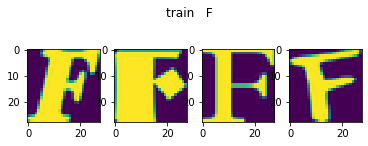

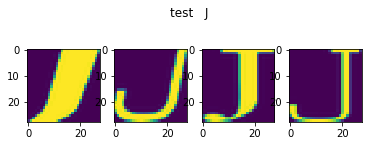

In [32]:
for key, folders in dataset.items():
    img_folder = random.choice(folders)

    with open(img_folder + '.pickle', 'rb') as f:
        arr = pickle.load(f)

    img_idx = random.sample(list(range(len(arr))), 4)
    plt.figure()
    plt.suptitle(key + '   ' + img_folder.split('/')[-1])
    for i, idx in enumerate(img_idx):
        plt.subplot(2, 4, i+1)
        plt.imshow(arr[idx])

---
Exercise 3
---------
Another check: we expect the data to be balanced across classes. Verify that if the number of samples across classes are balanced.

---

In [40]:
for key, folders in dataset.items():
    print('\n%s\n'%key)
    
    for folder in folders:
        print('original image # of %s : %d' % (folder, len(os.listdir(folder))))
        with open(folder + '.pickle', 'rb') as f:
            arr = pickle.load(f)
        print('successed # of converted to arr in %s: %d\n' % (folder, len(arr)))


train

original image # of ./data/notMNIST_large/A : 52912
successed # of converted to arr in ./data/notMNIST_large/A: 52909

original image # of ./data/notMNIST_large/B : 52912
successed # of converted to arr in ./data/notMNIST_large/B: 52911

original image # of ./data/notMNIST_large/C : 52912
successed # of converted to arr in ./data/notMNIST_large/C: 52912

original image # of ./data/notMNIST_large/D : 52912
successed # of converted to arr in ./data/notMNIST_large/D: 52911

original image # of ./data/notMNIST_large/E : 52912
successed # of converted to arr in ./data/notMNIST_large/E: 52912

original image # of ./data/notMNIST_large/F : 52912
successed # of converted to arr in ./data/notMNIST_large/F: 52912

original image # of ./data/notMNIST_large/G : 52912
successed # of converted to arr in ./data/notMNIST_large/G: 52912

original image # of ./data/notMNIST_large/H : 52912
successed # of converted to arr in ./data/notMNIST_large/H: 52912

original image # of ./data/notMNIST_larg

## Generate train, test, validation sets

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [43]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes

    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class

                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise

    return valid_dataset, valid_labels, train_dataset, train_labels

            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [44]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Exercise 4
---------
Convince yourself that the data is still good after shuffling! Display one of the images and see if it's not distorted.

---

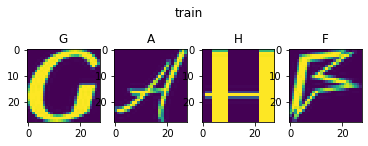

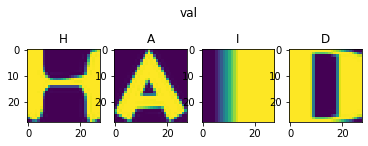

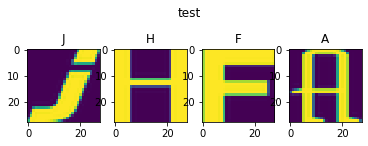

In [51]:
dataset = {'train': train_dataset, 'val': valid_dataset, 'test': test_dataset}
labels = {'train': train_labels, 'val': valid_labels, 'test': test_labels}
true_label = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}

for key, value in dataset.items():
    img_idx = random.sample(list(range(len(value))), 4)
    plt.figure()
    plt.suptitle(key)
    for i, idx in enumerate(img_idx):
        plt.subplot(2, 4, i+1)
        plt.title(true_label[labels[key][idx]])
        plt.imshow(value[idx])

Finally, let's save the data for later reuse:

In [52]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [53]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


---
Exercise 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Important Hint: Since the size of the dataset is large, it demands much time to search and compare. Using *hash, set* function in python may help.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [83]:
import hashlib
dataset = {'train': train_dataset, 'val': valid_dataset, 'test': test_dataset}
hash_dic = {}

for key, value in dataset.items():
    hash_dic[key] = [hashlib.sha256(arr).hexdigest() for arr in value]

In [98]:
def count_overlap(hash_dic1, hash_dic2):
    overlap_cnt=0
    for i, hash_value in enumerate(hash_dic1):
        if hash_value in hash_dic2:
            overlap_cnt+=1
    return overlap_cnt

In [99]:
print(count_overlap(hash_dic['train'], hash_dic['val']))
print(count_overlap(hash_dic['val'], hash_dic['test']))
print(count_overlap(hash_dic['test'], hash_dic['train']))

3451
190
1255


---
Problem
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using <font color='red'>$100,\ 500,\ 2500,\ and\ 10000$</font> training samples. *Hint*: Use LogisticRegression model from sklearn.linear_model. You do not need to care about FutureWarning in sklearn.

**Evaluation**: Demonstration of training results from different sizes of dataset with test data.

---

In [119]:
def logistic_regression(train_dataset, train_labels, test_dataset, test_labels):
    model = LogisticRegression()
    X_train = train_dataset.reshape(len(train_dataset), 28*28)
    X_test = test_dataset.reshape(len(test_dataset), 28*28)
    %time model.fit(X_train, train_labels)
    return model.score(X_test, test_labels)

In [121]:
print(logistic_regression(train_dataset[:100], train_labels[:100], test_dataset, test_labels))
print(logistic_regression(train_dataset[:500], train_labels[:500], test_dataset, test_labels))
print(logistic_regression(train_dataset[:2500], train_labels[:2500], test_dataset, test_labels))
print(logistic_regression(train_dataset[:10000], train_labels[:10000], test_dataset, test_labels))

/home/ajseo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ajseo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ajseo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ajseo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CPU times: user 90.3 ms, sys: 0 ns, total: 90.3 ms
Wall time: 89.3 ms
0.7519
CPU times: user 1.14 s, sys: 0 ns, total: 1.14 s
Wall time: 784 ms
0.8093


/home/ajseo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ajseo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CPU times: user 6.58 s, sys: 0 ns, total: 6.58 s
Wall time: 6.2 s
0.8367


/home/ajseo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ajseo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CPU times: user 39 s, sys: 0 ns, total: 39 s
Wall time: 38.6 s
0.8638
